In [1]:
# Imports
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

## Chargement des données

In [2]:
# Chargement des fichiers CSV en Polars
df_interaction = pl.read_csv("../data/raw/RAW_interactions.csv")
df_recipe = pl.read_csv("../data/raw/RAW_recipes.csv")

# Aperçu
df_interaction.head()

user_id,recipe_id,date,rating,review
i64,i64,str,i64,str
38094,40893,"""2003-02-17""",4,"""Great with a salad. Cooked on …"
1293707,40893,"""2011-12-21""",5,"""So simple, so delicious! Great…"
8937,44394,"""2002-12-01""",4,"""This worked very well and is E…"
126440,85009,"""2010-02-27""",5,"""I made the Mexican topping and…"
57222,85009,"""2011-10-01""",5,"""Made the cheddar bacon topping…"


## Distribution des notes

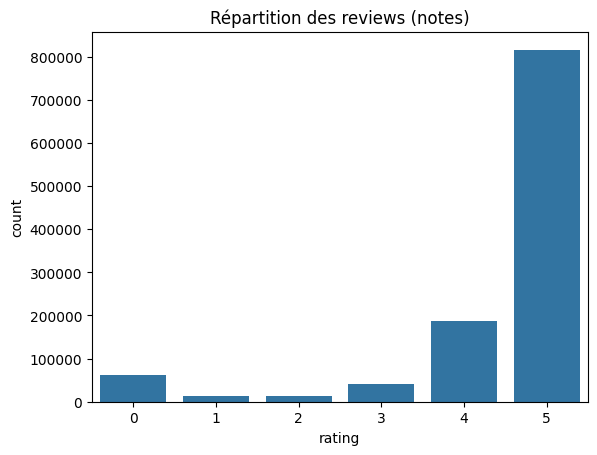

Note moyenne globale : 4.41


In [3]:
# Utiliser to_pandas() pour les visualisations (Seaborn attend pandas)
sns.countplot(x="rating", data=df_interaction.to_pandas())
plt.title("Répartition des reviews (notes)")
plt.show()

mean_rating = df_interaction.select(pl.col("rating").mean()).item()
print(f"Note moyenne globale : {mean_rating:.2f}")

## Distribution du nombre de reviews par recette

/var/folders/73/zx24sp5s3sn2p2j35t94kt6h0000gn/T/ipykernel_61526/2115211475.py:5: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("nb_reviews"))


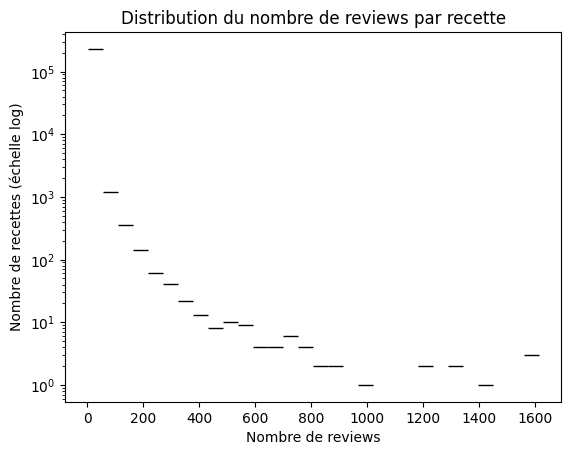

In [4]:
# Comptage des reviews par recette (Polars)
reviews_per_recipe = (
    df_interaction
    .group_by("recipe_id")
    .agg(pl.count().alias("nb_reviews"))
)

# Visualisation (convertir en pandas)
sns.histplot(reviews_per_recipe["nb_reviews"].to_pandas(), bins=30, log_scale=(False, True))
plt.title("Distribution du nombre de reviews par recette")
plt.xlabel("Nombre de reviews")
plt.ylabel("Nombre de recettes (échelle log)")
plt.show()

Here, the graph shows a highly unbalanced distribution : the majority of recipes have only a small number of reviews, while a minority attract a huge number of comments.
This illustrates a “long tail” phenomenon: a handful of very popular recipes generate a large part of the activity, while most remain largely unrated.
On a logarithmic scale, this inequality becomes more visible.

## Top des recettes les plus commentées

/var/folders/73/zx24sp5s3sn2p2j35t94kt6h0000gn/T/ipykernel_61526/2917349450.py:6: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("nb_reviews"))
/var/folders/73/zx24sp5s3sn2p2j35t94kt6h0000gn/T/ipykernel_61526/2917349450.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


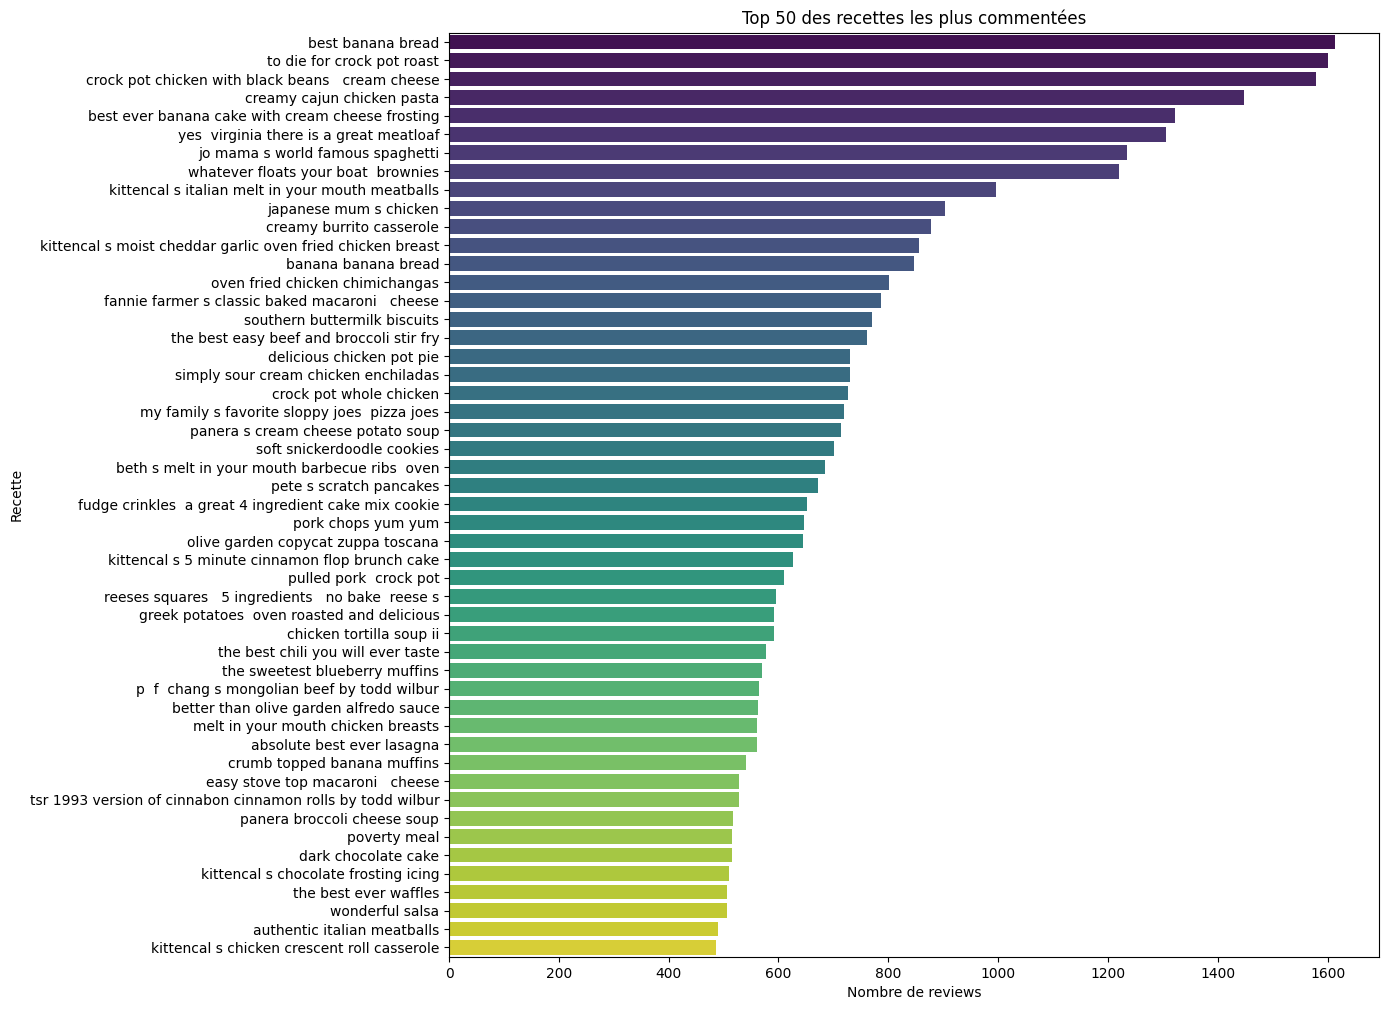

In [5]:
nb_recettes = 50

top_recipes = (
    df_interaction
    .group_by("recipe_id")
    .agg(pl.count().alias("nb_reviews"))
    .sort("nb_reviews", descending=True)
    .head(nb_recettes)
)

top_recipes_df = top_recipes.join(
    df_recipe.select(["id", "name"]),
    left_on="recipe_id",
    right_on="id",
    how="left"
)

plt.figure(figsize=(12, 12))
sns.barplot(
    data=top_recipes_df.to_pandas().sort_values("nb_reviews", ascending=False),
    x="nb_reviews", y="name",palette='viridis'
)
plt.title(f"Top {nb_recettes} des recettes les plus commentées")
plt.xlabel("Nombre de reviews")
plt.ylabel("Recette")
plt.show()

This graph highlights the platform's most engaging recipes. These recipes, often simple, universal, or viral, such as the "best banana bread", generate a lot of interest and interaction. Identifying these recipes would help us understand what types of dishes appeal most to the community.

## Moyenne des notes et nombre de reviews par recette

/var/folders/73/zx24sp5s3sn2p2j35t94kt6h0000gn/T/ipykernel_61526/605500454.py:7: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("nb_reviews")
/var/folders/73/zx24sp5s3sn2p2j35t94kt6h0000gn/T/ipykernel_61526/605500454.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_best.to_pandas(), x='mean_rating', y='name',palette='crest')


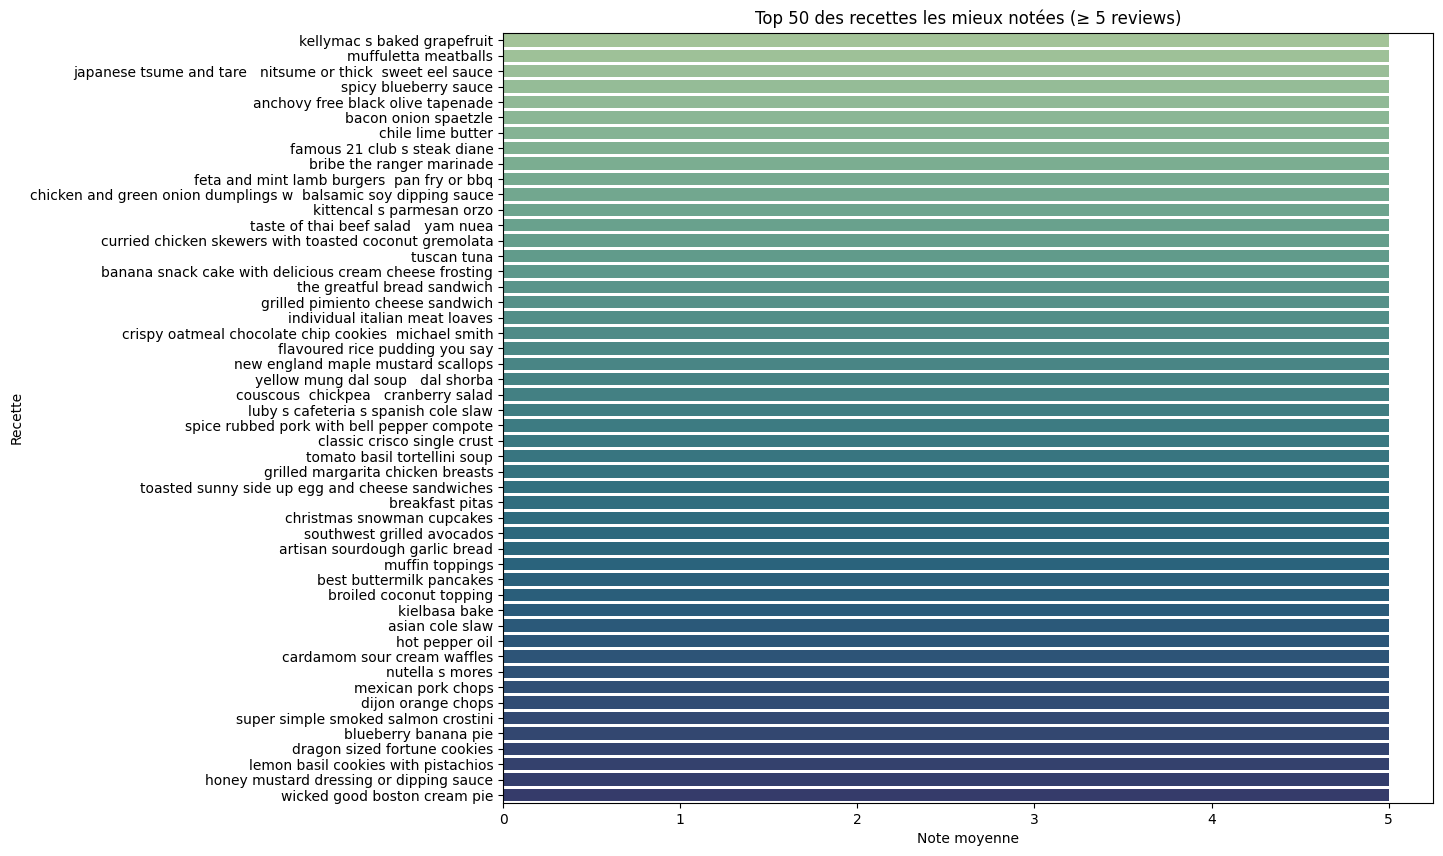

/var/folders/73/zx24sp5s3sn2p2j35t94kt6h0000gn/T/ipykernel_61526/605500454.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_worst.to_pandas(), x='mean_rating', y='name',palette='rocket')


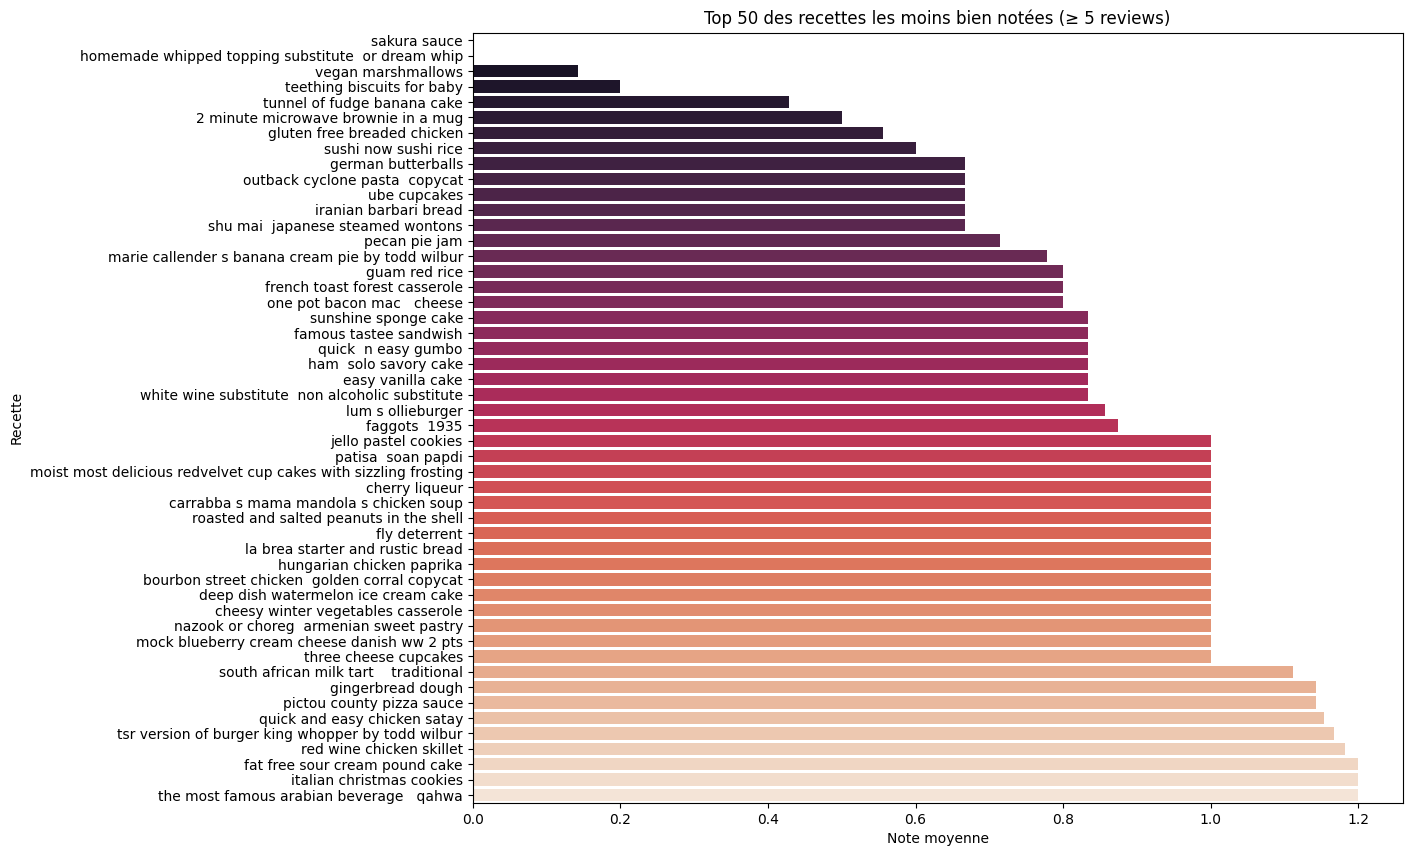

In [6]:
# Calculer la moyenne des notes et le nombre de reviews par recette (Polars)
recipe_ratings = (
    df_interaction
    .group_by("recipe_id")
    .agg([
        pl.col("rating").mean().alias("mean_rating"),
        pl.count().alias("nb_reviews")
    ])
)

# Joindre avec df_recipe pour récupérer le nom
recipe_ratings = recipe_ratings.join(
    df_recipe.select(["id", "name"]),
    left_on="recipe_id",
    right_on="id",
    how="left"
)

# Filtrer pour garder seulement les recettes avec au moins 5 reviews
filtered_recipes = recipe_ratings.filter(pl.col("nb_reviews") >= 5)

# Top des mieux et moins bien notées
top_best = filtered_recipes.sort("mean_rating", descending=True).head(nb_recettes)
top_worst = filtered_recipes.sort("mean_rating", descending=False).head(nb_recettes)

# Visualisation (convertir en pandas pour seaborn)
plt.figure(figsize=(12, 10))
sns.barplot(data=top_best.to_pandas(), x='mean_rating', y='name',palette='crest')
plt.title(f"Top {nb_recettes} des recettes les mieux notées (≥ 5 reviews)")
plt.xlabel("Note moyenne")
plt.ylabel("Recette")
plt.show()

plt.figure(figsize=(12, 10))
sns.barplot(data=top_worst.to_pandas(), x='mean_rating', y='name',palette='rocket')
plt.title(f"Top {nb_recettes} des recettes les moins bien notées (≥ 5 reviews)")
plt.xlabel("Note moyenne")
plt.ylabel("Recette")
plt.show()

- Top-rated recipes :  
These recipes stand out thanks to their exceptional average rating and sufficient number of reviews to be considered reliable. They represent a benchmark of quality on the platform. They could be highlighted in a recommendation strategy.  
- Least popular recipes : 
At the other end, these recipes have received poor ratings despite several reviews. This may indicate problems with the recipe (measurements, cooking time, instructions) or unmet expectations. These extreme cases are useful for analyzing areas for improvement or identifying common mistakes.

## Nombre de reviews par utilisateur & catégorisation

/var/folders/73/zx24sp5s3sn2p2j35t94kt6h0000gn/T/ipykernel_61526/3200265066.py:5: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("nb_reviews"))


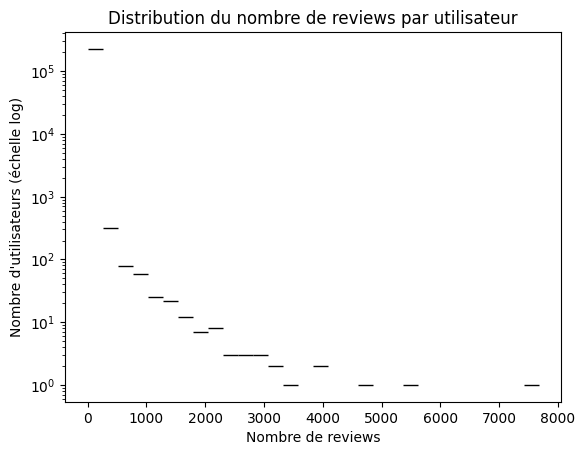

/var/folders/73/zx24sp5s3sn2p2j35t94kt6h0000gn/T/ipykernel_61526/3200265066.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=user_categories.index, y=user_categories.values,palette='Blues_r')


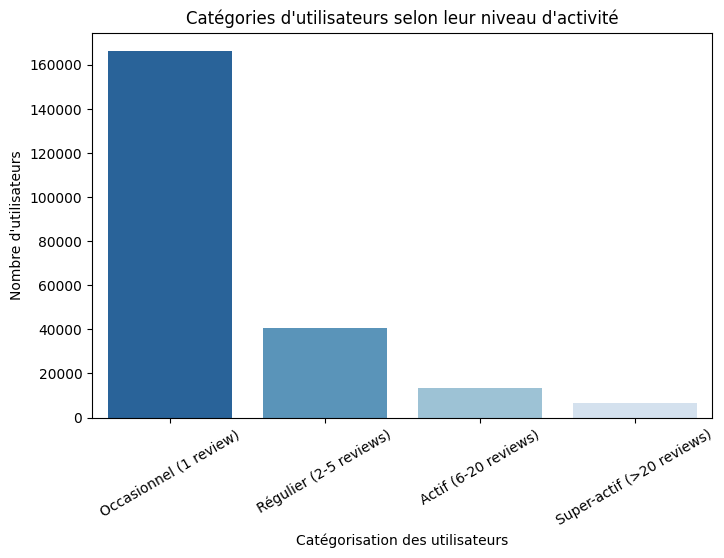

In [7]:
# Reviews par utilisateur (Polars)
reviews_per_user = (
    df_interaction
    .group_by("user_id")
    .agg(pl.count().alias("nb_reviews"))
)

# Pour la visualisation, convertir en pandas
sns.histplot(reviews_per_user["nb_reviews"].to_pandas(), bins=30, log_scale=(False, True))
plt.title("Distribution du nombre de reviews par utilisateur")
plt.xlabel("Nombre de reviews")
plt.ylabel("Nombre d'utilisateurs (échelle log)")
plt.show()

# Catégorisation des utilisateurs : on utilise pandas pour l'opération apply simple
reviews_per_user_pd = reviews_per_user.to_pandas().set_index('user_id')

def categorize_user(n):
    if n == 1:
        return "Occasionnel (1 review)"
    elif n <= 5:
        return "Régulier (2-5 reviews)"
    elif n <= 20:
        return "Actif (6-20 reviews)"
    else:
        return "Super-actif (>20 reviews)"

user_categories = reviews_per_user_pd['nb_reviews'].apply(categorize_user).value_counts()

plt.figure(figsize=(8,5))
sns.barplot(x=user_categories.index, y=user_categories.values,palette='Blues_r')
plt.title("Catégories d'utilisateurs selon leur niveau d'activité")
plt.ylabel("Nombre d'utilisateurs")
plt.xlabel("Catégorisation des utilisateurs")
plt.xticks(rotation=30)
plt.show()

- Distribution of the number of reviews per user :  
The majority of users leave only one review: many are occasional users. In contrast, a minority of very active users produce a large volume of comments. This reflects a two-tiered community: many passive consumers and a few loyal contributors. We observe that someone has made approximateky 7500 reviews. This is surely either a bot or an enthusiast.  
- Categorization of users according to their activity : 
We observe that “occasional” users dominate, followed by a smaller core of regular and active users. “Super-active” users (>20 reviews) are rare but essential: they drive the platform and generate quality content. This typology would allow us to adapt our community engagement strategy.

## Top utilisateurs les plus actifs & moyenne des notes par utilisateur

In [8]:
# Top 10 des utilisateurs les plus actifs (Polars -> pandas pour facilité)
top_users = (
    df_interaction
    .group_by("user_id")
    .agg(pl.count().alias("nb_reviews"))
    .sort("nb_reviews", descending=True)
    .head(10)
)

top_users_list = top_users['user_id'].to_list()

# Filtrer le dataset original pour ne garder que ces contributeurs (Polars)
df_top_users = df_interaction.filter(pl.col('user_id').is_in(top_users_list))

# Moyenne des notes par utilisateur (Polars)
mean_rating_per_user = (
    df_top_users
    .group_by('user_id')
    .agg(pl.col('rating').mean().alias('mean_rating'))
    .sort('mean_rating', descending=True)
)

mean_rating_per_user_pd = mean_rating_per_user.to_pandas().set_index('user_id')
print(mean_rating_per_user_pd)

         mean_rating
user_id             
424680      4.966888
89831       4.940352
305531      4.939697
128473      4.908348
199848      4.831014
37449       4.783866
383346      4.755186
133174      4.720953
169430      4.693327
58104       4.641727


/var/folders/73/zx24sp5s3sn2p2j35t94kt6h0000gn/T/ipykernel_61526/4081355831.py:5: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("nb_reviews"))


## Statistiques utilisateurs : nb_reviews vs mean_rating

/var/folders/73/zx24sp5s3sn2p2j35t94kt6h0000gn/T/ipykernel_61526/1887841544.py:5: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias('nb_reviews'),


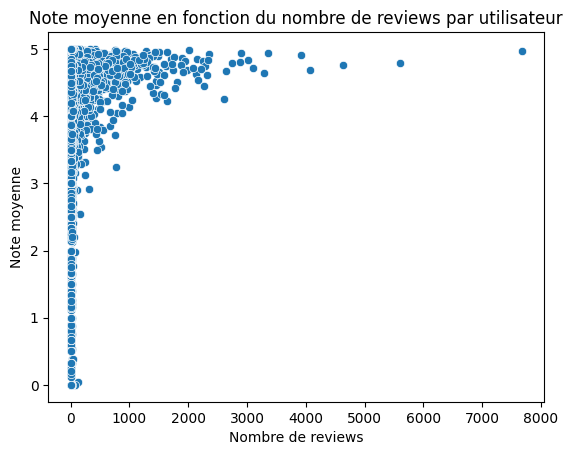

In [9]:
df_user_stats = (
    df_interaction
    .group_by('user_id')
    .agg([
        pl.count().alias('nb_reviews'),
        pl.col('rating').mean().alias('mean_rating')
    ])
)

# Scatter plot (convert to pandas)
df_user_stats_pd = df_user_stats.to_pandas()
sns.scatterplot(x='nb_reviews', y='mean_rating', data=df_user_stats_pd)
plt.xlabel("Nombre de reviews")
plt.ylabel("Note moyenne")
plt.title("Note moyenne en fonction du nombre de reviews par utilisateur")
plt.show()

## Séries temporelles : extraction année/mois et évolution des notes & counts

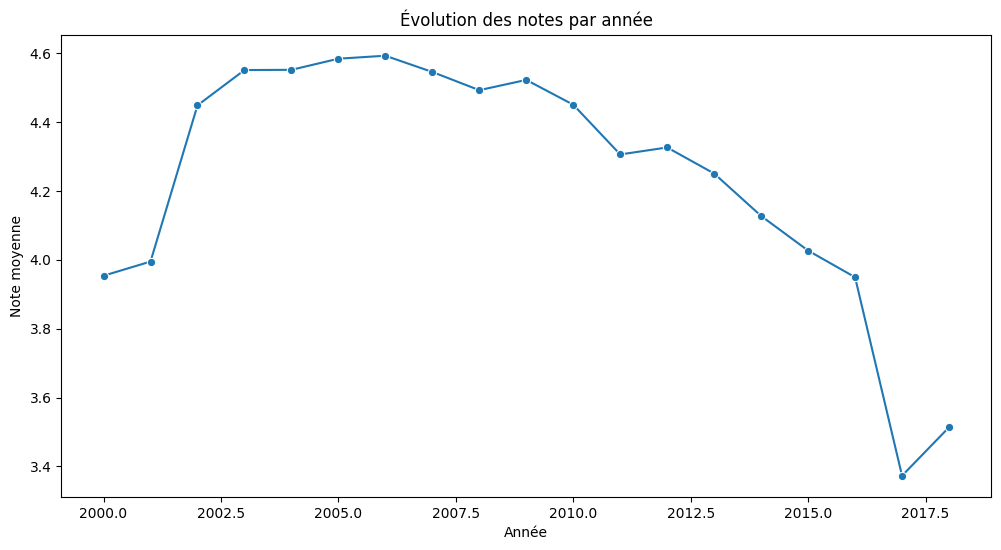

/var/folders/73/zx24sp5s3sn2p2j35t94kt6h0000gn/T/ipykernel_61526/1257979690.py:32: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias('nb_reviews'))


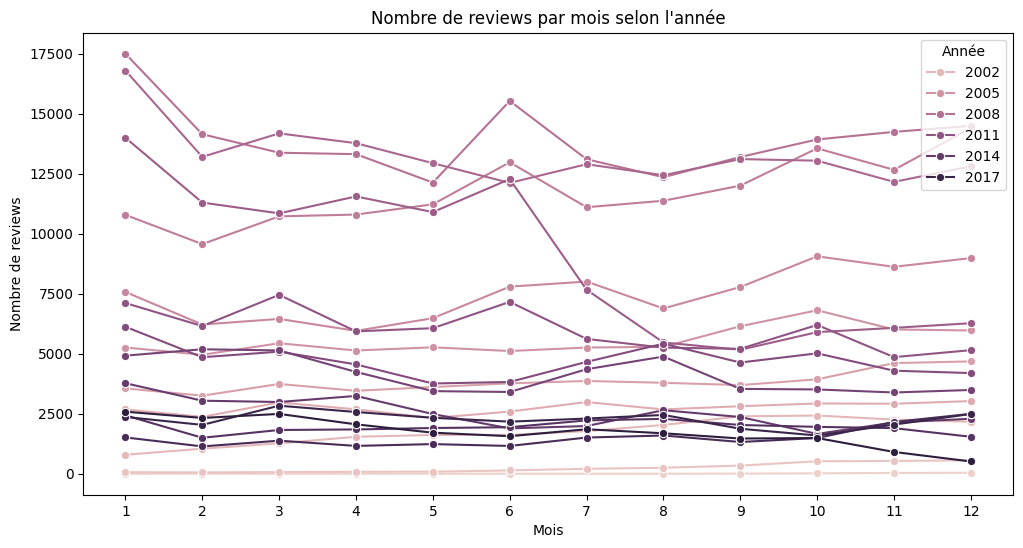

In [10]:
# S'assurer que la colonne 'date' est bien en datetime (Polars)
# On essaye de parser automatiquement ; adapter le format si nécessaire.
df_interaction = df_interaction.with_columns([
    pl.col('date').str.strptime(pl.Datetime, strict=False).alias('date_parsed')
])

# Extraire année et mois
df_interaction = df_interaction.with_columns([
    pl.col('date_parsed').dt.year().alias('year'),
    pl.col('date_parsed').dt.month().alias('month')
])

# Moyenne des notes par année
monthly_ratings = (
    df_interaction
    .group_by('year')
    .agg(pl.col('rating').mean().alias('mean_rating'))
    .sort('year')
)

plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_ratings.to_pandas(), x='year', y='mean_rating', marker='o')
plt.xlabel("Année")
plt.ylabel("Note moyenne")
plt.title("Évolution des notes par année")
plt.show()

# Nombre de reviews par (année, mois)
monthly_counts = (
    df_interaction
    .group_by(['year','month'])
    .agg(pl.count().alias('nb_reviews'))
    .sort(['year','month'])
)

# Convertir et tracer (hue=year)
monthly_counts_pd = monthly_counts.to_pandas()
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_counts_pd, x='month', y='nb_reviews', hue='year', marker='o')
plt.xticks(range(1,13))
plt.xlabel("Mois")
plt.ylabel("Nombre de reviews")
plt.title("Nombre de reviews par mois selon l'année")
plt.legend(title="Année")
plt.show()

- Change in average score per year :  
Here, the average recipe rating rose steadily between 2000 and 2006, from around 3.9 to 4.6, reflecting a very positive initial phase in which users generously rated the most popular recipes. From 2007 onwards, the trend reversed: ratings gradually declined to around 3.4 in 2017, which may reflect a diversification of content, a broader audience, or a more critical assessment of recipes over time.
- Number of reviews per month and per year :  
The number of reviews does not show any marked seasonal peaks, suggesting relatively stable activity throughout the year. However, there was a gradual decline in the volume of reviews between 2002 and 2017, indicating a decline in community engagement over time, possibly linked to a loss of interest in the platform or competition from other recipe-sharing sites.